Parameters

In [1]:
# Extension for match file
extension = '_0004UD'

# Timestamp to generate pitch control model
timestamp = '2024-05-15 17:59:43+00:00'

# Define team names 
team1 = 'MLS-CLU-00000M'
team2 = 'MLS-CLU-000009'



In [2]:
import pandas as pd



# Load the data
data = pd.read_csv(f'tracking_data_with_velocity{extension}.csv')

# Convert 'TimeStamp' to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])

# Set 'TimeStamp' as the index
data.set_index('TimeStamp', inplace=True)

# Sort the data by 'TimeStamp'
data.sort_index(inplace=True)

Groups data with timestamps as the keys and dataframes as the values

In [3]:
def create_positions_by_timestamp(data):
    positions_by_timestamp = {}
    for timestamp, group in data.groupby(level=0):
        # Ensure only unique positions per player per timestamp
        group = group.drop_duplicates(subset=['TeamId', 'PersonId'])
        positions_by_timestamp[timestamp] = group
    return positions_by_timestamp

positions_by_timestamp = create_positions_by_timestamp(data)

Returns dataframe with data for chosen timestamp

In [4]:
def extract_positions_for_timestamp(positions_by_timestamp, timestamp):
    # Convert to Pandas Timestamp to ensure correct matching
    timestamp = pd.Timestamp(timestamp)
    
    # Extract the data for the specified timestamp
    if timestamp in positions_by_timestamp:
        return positions_by_timestamp[timestamp]
    else:
        print(f"No data available for timestamp: {timestamp}")
        return None

# Example timestamp
# timestamp = '2024-05-15 17:59:43+00:00'

#timestamp = '2024-02-25T16:52:19.320+00:00'

# Extract positions for the specified timestamp
positions_at_timestamp = extract_positions_for_timestamp(positions_by_timestamp, timestamp)

Plotting for positions and velocity vectors at timestamp

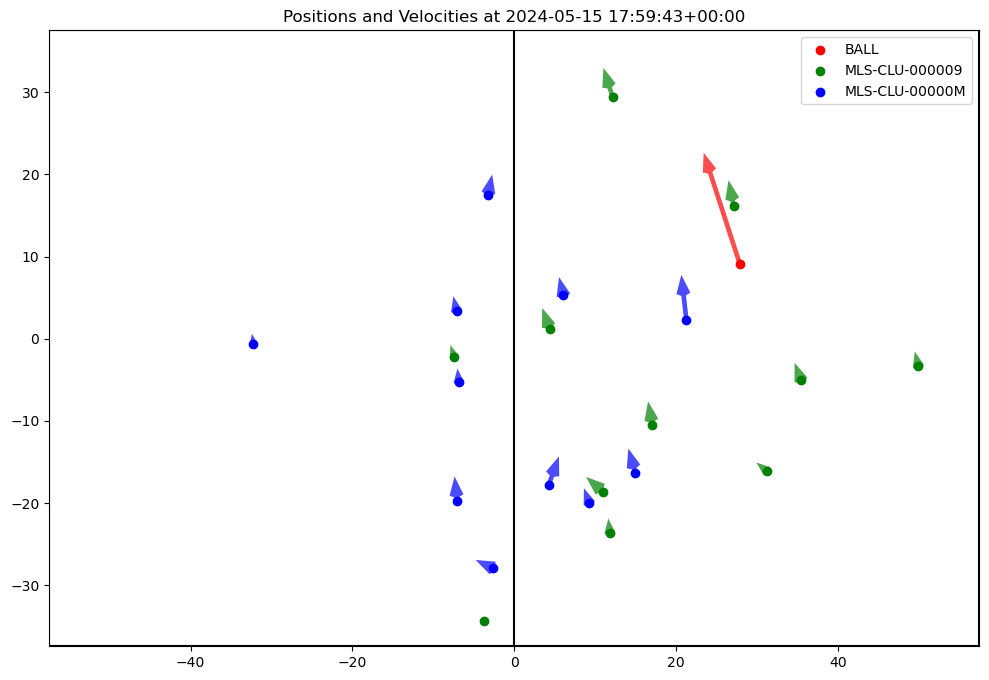

In [5]:
import matplotlib.pyplot as plt

def plot_positions(positions, timestamp, pitch_dims_x=(-57.48, 57.46), pitch_dims_y=(-37.42, 37.53)):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw the pitch
    ax.set_xlim(pitch_dims_x[0], pitch_dims_x[1])
    ax.set_ylim(pitch_dims_y[0], pitch_dims_y[1])
    ax.plot([pitch_dims_x[0], pitch_dims_x[0], pitch_dims_x[1], pitch_dims_x[1], pitch_dims_x[0]], 
            [pitch_dims_y[0], pitch_dims_y[1], pitch_dims_y[1], pitch_dims_y[0], pitch_dims_y[0]], color='black')
    
    # Draw halfway line
    ax.plot([0, 0], [pitch_dims_y[0], pitch_dims_y[1]], color='black')
    
    # Define colors for each team
    team_colors = {
        'MLS-CLU-00000M': 'blue',
        'MLS-CLU-000009': 'green',
        'BALL': 'red'
    }
    
    # Plot players and velocity vectors
    for team_id, group in positions.groupby('TeamId'):
        color = team_colors.get(team_id, 'gray')
        ax.scatter(group['x-Position'], group['y-Position'], label=team_id, color=color)
        
        # Add velocity vectors with color-coding
        ax.quiver(
            group['x-Position'], 
            group['y-Position'], 
            group['XVel'], 
            group['YVel'], 
            angles='xy', scale_units='xy', scale=1, color=color, alpha=0.7,
            headwidth=3, headlength=4, width=0.005
        )
    
    # Plot the ball
    ball_position = positions[positions['PersonId'] == 'BALL']
    if not ball_position.empty:
        ax.scatter(ball_position['x-Position'], ball_position['y-Position'], color='red', label='BALL', s=100)
    
    ax.legend(loc='upper right')
    plt.title(f"Positions and Velocities at {timestamp}")
    plt.show()

# Plot the positions and velocities at the specified timestamp
if positions_at_timestamp is not None:
    plot_positions(positions_at_timestamp, timestamp)
else:
    print("No data available for the specified timestamp.")


Calculates Pitch Control

In [6]:
import numpy as np
import pandas as pd

def sigmoid(x, k=1, x0=0):
    """
    Sigmoid function to model uncertainty in arrival times.
    """
    return 1 / (1 + np.exp(-k * (x - x0)))

def control_probability(t, lambda_=4.3):
    """
    Calculate the control probability given the time difference t.
    """
    return 1 - np.exp(-lambda_ * t)

def arrival_time(x, y, player_x, player_y, player_vx, player_vy, reaction_time=0.7, max_speed=5):
    """
    Calculate the arrival time for a player to reach a target location (x, y).
    """
    new_x = player_x + player_vx * reaction_time
    new_y = player_y + player_vy * reaction_time
    dist = np.sqrt((x - new_x)**2 + (y - new_y)**2)
    t_run = dist / max_speed
    time_total = t_run + reaction_time
    return time_total

def ball_arrival_time(x, y, ball_x, ball_y, ball_speed=15.0):
    dist = np.sqrt((x - ball_x)**2 + (y - ball_y)**2)
    time = dist / ball_speed 
    return time

def adjusted_control_probability(t_diff, lambda_=4.3):
    """
    Calculate the adjusted control probability for a player considering the time they have before opponents arrive.
    """
    if t_diff > 0:
        P_control = control_probability(t_diff, lambda_)
    else:
        P_control = 0
    return P_control

def calculate_pitch_control(positions, pitch_dims_x=(-57.48, 57.46), pitch_dims_y=(-37.42, 37.53), grid_size=0.5):
    """
    Calculate the pitch control probabilities for each team over the entire pitch.
    """
    x_range = np.arange(pitch_dims_x[0], pitch_dims_x[1], grid_size)
    y_range = np.arange(pitch_dims_y[0], pitch_dims_y[1], grid_size)
    pitch_control = np.zeros((len(y_range), len(x_range), 2))  # 2 teams

    # Retrieve Ball Data
    ball_row = positions[positions['TeamId'] == 'BALL']
    ball_x = ball_row.iloc[0]['x-Position']
    ball_y = ball_row.iloc[0]['y-Position']

    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            
            # Calculate ball arrival time at this location

            ball_arrival_t = ball_arrival_time(x, y, ball_x, ball_y)

            player_times = []
            for index, row in positions.iterrows():
                t_player = arrival_time(x, y, row['x-Position'], row['y-Position'], row['XVel'], row['YVel'])
                player_times.append((t_player, row['TeamId']))

            player_times.sort()  # Sort players by arrival time
            top_3 = player_times[:3]  # Get the top 3 players with the fastest arrival times

            # Calculate control probabilities for the top 3 players
            control_probs = []
            total_control_prob = 0

            for k, (t_player, team) in enumerate(top_3):
                if k == 0:
                    if t_player < ball_arrival_t:
                        t_diff = top_3[1][0] - ball_arrival_t  # Ball arrives after player 1, before player 2
                    else:
                        t_diff = top_3[1][0] - t_player  # Player 1 arrives after ball, before player 2
                else:
                    t_diff = top_3[k+1][0] - t_player if k+1 < len(top_3) else 1  # Time between this player and the next player

                # Calculates control probability for given increment of time
                P_control = adjusted_control_probability(t_diff)
                remaining_prob = 1 - total_control_prob
                split_prob = P_control * remaining_prob
                # Adds split up control probabilities to existing entries in list
                control_probs = [(p[0] + split_prob / (k + 1), p[1]) for p in control_probs]
                # Appends new entry/control probability 
                control_probs.append((split_prob / (k + 1), team))
                total_control_prob += split_prob


            
            # team1 = 'MLS-CLU-00000M'
            # team2 = 'MLS-CLU-000009'


            # Sum control probabilities for each team
            team1_control = sum([p[0] for p in control_probs if p[1] == team1])
            team2_control = sum([p[0] for p in control_probs if p[1] == team2])

            total_control = team1_control + team2_control

            if total_control > 0:
                pitch_control[j, i, 0] = team1_control / total_control
                pitch_control[j, i, 1] = team2_control / total_control
            else:
                pitch_control[j, i, 0] = 0
                pitch_control[j, i, 1] = 0

    return pitch_control, x_range, y_range

Converts Timestamp into Game Minute and Second

In [7]:
from datetime import datetime, timedelta
# Start of Match
start_of_match_dt = data.index[0]

# Start of Second Half 
data_temp = data[data['GameSection'] == 'secondHalf']

start_of_second_half_dt = data_temp.index[0]

timestamp_dt = datetime.fromisoformat(timestamp)

if timestamp_dt > start_of_second_half_dt:
    timestamp_diff = timestamp_dt - start_of_second_half_dt + timedelta(minutes=45)
else:
    timestamp_diff = timestamp_dt - start_of_match_dt

timestamp_diff_seconds = timestamp_diff.total_seconds()
timestamp_minute = int(timestamp_diff_seconds // 60)
timestamp_second = round(timestamp_diff_seconds % 60, 2)



Plots Pitch Control

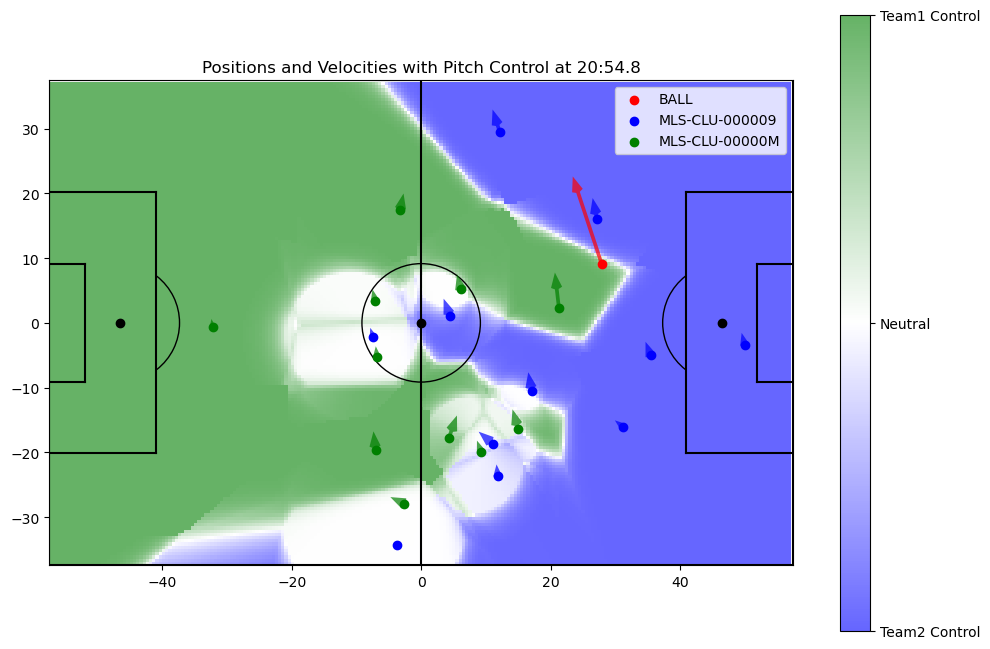

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import numpy as np
import pandas as pd

def plot_positions_with_control(positions, pitch_control, x_range, y_range, timestamp, pitch_dims_x=(-57.48, 57.46), pitch_dims_y=(-37.42, 37.53)):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw the pitch
    ax.set_xlim(pitch_dims_x[0], pitch_dims_x[1])
    ax.set_ylim(pitch_dims_y[0], pitch_dims_y[1])
    ax.plot([pitch_dims_x[0], pitch_dims_x[0], pitch_dims_x[1], pitch_dims_x[1], pitch_dims_x[0]], 
            [pitch_dims_y[0], pitch_dims_y[1], pitch_dims_y[1], pitch_dims_y[0], pitch_dims_y[0]], color='black')
    
    # Draw halfway line
    ax.plot([0, 0], [pitch_dims_y[0], pitch_dims_y[1]], color='black')

    # Draw the penalty areas
    penalty_area_width = 16.5
    penalty_area_height = 40.3 / 2
    
    # Left penalty area
    ax.plot([-57.48, -57.48 + penalty_area_width], [-penalty_area_height, -penalty_area_height], color='black')
    ax.plot([-57.48, -57.48 + penalty_area_width], [penalty_area_height, penalty_area_height], color='black')
    ax.plot([-57.48 + penalty_area_width, -57.48 + penalty_area_width], [-penalty_area_height, penalty_area_height], color='black')
    
    # Right penalty area
    ax.plot([57.46, 57.46 - penalty_area_width], [-penalty_area_height, -penalty_area_height], color='black')
    ax.plot([57.46, 57.46 - penalty_area_width], [penalty_area_height, penalty_area_height], color='black')
    ax.plot([57.46 - penalty_area_width, 57.46 - penalty_area_width], [-penalty_area_height, penalty_area_height], color='black')
    
    # Draw the goal areas
    goal_area_width = 5.5
    goal_area_height = 18.32 / 2
    
    # Left goal area
    ax.plot([-57.48, -57.48 + goal_area_width], [-goal_area_height, -goal_area_height], color='black')
    ax.plot([-57.48, -57.48 + goal_area_width], [goal_area_height, goal_area_height], color='black')
    ax.plot([-57.48 + goal_area_width, -57.48 + goal_area_width], [-goal_area_height, goal_area_height], color='black')
    
    # Right goal area
    ax.plot([57.46, 57.46 - goal_area_width], [-goal_area_height, -goal_area_height], color='black')
    ax.plot([57.46, 57.46 - goal_area_width], [goal_area_height, goal_area_height], color='black')
    ax.plot([57.46 - goal_area_width, 57.46 - goal_area_width], [-goal_area_height, goal_area_height], color='black')
    
    # Draw the penalty spots
    ax.scatter([-57.48 + 11, 57.46 - 11], [0, 0], color='black')
    
    # Draw the center circle and spot
    center_circle_radius = 9.15
    center_circle = plt.Circle((0, 0), center_circle_radius, color='black', fill=False)
    ax.add_artist(center_circle)
    ax.scatter([0], [0], color='black')
    
    # Draw the arcs of the penalty areas
    left_arc = patches.Arc((-57.48 + 11, 0), height=18.3, width=18.3, angle=0, theta1=308, theta2=52, color='black')
    right_arc = patches.Arc((57.46 - 11, 0), height=18.3, width=18.3, angle=0, theta1=128, theta2=232, color='black')
    ax.add_artist(left_arc)
    ax.add_artist(right_arc)

    # Normalize pitch control values to [0, 1]
    team1_control = pitch_control[:, :, 0]
    team2_control = pitch_control[:, :, 1]

    
    control_sum = team1_control + team2_control

    team1_control = np.where(control_sum == 0, 0, team1_control / control_sum)
    team2_control = np.where(control_sum == 0, 0, team2_control / control_sum)

    # Create a custom colormap for blending blue, green, and white
    colors = ['blue', 'white', 'green']
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Create an array for the blended control map
    control_map = team1_control - team2_control

    # Plot combined control map
    cax = ax.imshow(control_map, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], origin='lower', cmap=cmap, vmin=-1, vmax=1, alpha=0.6)
    
    # Add color bar
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(['Team2 Control', 'Neutral', 'Team1 Control'])


    
    # Define team colors
    team_colors = {
        team1: 'green',
        team2: 'blue',
        'BALL': 'red'
    }
    
    # Plot players and velocity vectors
    for team_id, group in positions.groupby('TeamId'):
        color = team_colors.get(team_id, 'gray')
        ax.scatter(group['x-Position'], group['y-Position'], label=team_id, color=color)
        
        # Add velocity vectors with color-coding
        ax.quiver(
            group['x-Position'], 
            group['y-Position'], 
            group['XVel'], 
            group['YVel'], 
            angles='xy', scale_units='xy', scale=1, color=color, alpha=0.7,
            headwidth=3, headlength=4, width=0.005
        )
    
    # Plot the ball
    ball_position = positions[positions['PersonId'] == 'BALL']
    if not ball_position.empty:
        ax.scatter(ball_position['x-Position'], ball_position['y-Position'], color='red', label='BALL', s=100)
    
    ax.legend(loc='upper right')
    plt.title(f"Positions and Velocities with Pitch Control at {timestamp_minute}:{timestamp_second}")
    plt.show()

# Example usage (assuming positions_at_timestamp, calculate_pitch_control, and timestamp are defined)
if positions_at_timestamp is not None:
    pitch_control, x_range, y_range = calculate_pitch_control(positions_at_timestamp)
    plot_positions_with_control(positions_at_timestamp, pitch_control, x_range, y_range, timestamp)
else:
    print("No data available for the specified timestamp.")


Calculates Aggregated Pitch Control

In [9]:
# Calculates pitch control once for every n frames (data contains 25 frames per second)
n = 1500

# Dimension of each grid on the pitch control model (meters)
grid_size = 2

pitch_dims_x = (-57.48, 57.46)
pitch_dims_y = (-37.42, 37.53)


x_range = np.arange(pitch_dims_x[0], pitch_dims_x[1], grid_size)
y_range = np.arange(pitch_dims_y[0], pitch_dims_y[1], grid_size)
total_pitch_control = np.zeros((len(y_range), len(x_range), 2))  # 2 teams

count = 0
for index, timestamp in enumerate(positions_by_timestamp):
    if index % n == 0:
        count += 1
        temp_positions_at_timestamp = extract_positions_for_timestamp(positions_by_timestamp, timestamp)
        temp_pitch_control, x_range, y_range = calculate_pitch_control(temp_positions_at_timestamp, grid_size=grid_size)
        total_pitch_control += temp_pitch_control

In [10]:
total_pitch_control = total_pitch_control / count

Plots Aggregated Pitch Control

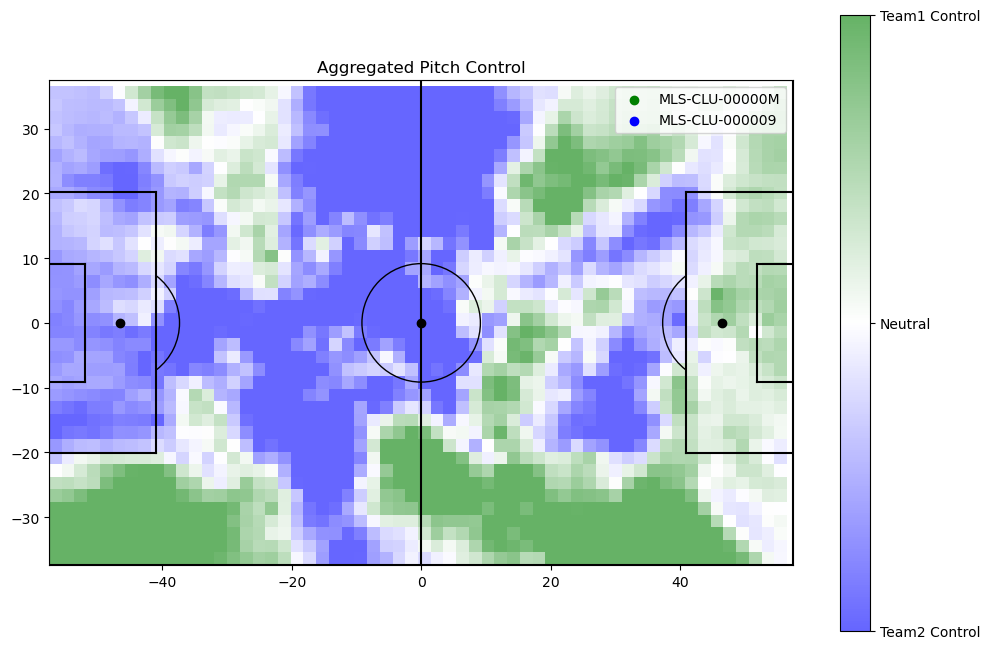

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import numpy as np
import pandas as pd

def plot_aggregated_control(pitch_control, x_range, y_range, pitch_dims_x=(-57.48, 57.46), pitch_dims_y=(-37.42, 37.53)):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw the pitch
    ax.set_xlim(pitch_dims_x[0], pitch_dims_x[1])
    ax.set_ylim(pitch_dims_y[0], pitch_dims_y[1])
    ax.plot([pitch_dims_x[0], pitch_dims_x[0], pitch_dims_x[1], pitch_dims_x[1], pitch_dims_x[0]], 
            [pitch_dims_y[0], pitch_dims_y[1], pitch_dims_y[1], pitch_dims_y[0], pitch_dims_y[0]], color='black')
    
    # Draw halfway line
    ax.plot([0, 0], [pitch_dims_y[0], pitch_dims_y[1]], color='black')

    # Draw the penalty areas
    penalty_area_width = 16.5
    penalty_area_height = 40.3 / 2
    
    # Left penalty area
    ax.plot([-57.48, -57.48 + penalty_area_width], [-penalty_area_height, -penalty_area_height], color='black')
    ax.plot([-57.48, -57.48 + penalty_area_width], [penalty_area_height, penalty_area_height], color='black')
    ax.plot([-57.48 + penalty_area_width, -57.48 + penalty_area_width], [-penalty_area_height, penalty_area_height], color='black')
    
    # Right penalty area
    ax.plot([57.46, 57.46 - penalty_area_width], [-penalty_area_height, -penalty_area_height], color='black')
    ax.plot([57.46, 57.46 - penalty_area_width], [penalty_area_height, penalty_area_height], color='black')
    ax.plot([57.46 - penalty_area_width, 57.46 - penalty_area_width], [-penalty_area_height, penalty_area_height], color='black')
    
    # Draw the goal areas
    goal_area_width = 5.5
    goal_area_height = 18.32 / 2
    
    # Left goal area
    ax.plot([-57.48, -57.48 + goal_area_width], [-goal_area_height, -goal_area_height], color='black')
    ax.plot([-57.48, -57.48 + goal_area_width], [goal_area_height, goal_area_height], color='black')
    ax.plot([-57.48 + goal_area_width, -57.48 + goal_area_width], [-goal_area_height, goal_area_height], color='black')
    
    # Right goal area
    ax.plot([57.46, 57.46 - goal_area_width], [-goal_area_height, -goal_area_height], color='black')
    ax.plot([57.46, 57.46 - goal_area_width], [goal_area_height, goal_area_height], color='black')
    ax.plot([57.46 - goal_area_width, 57.46 - goal_area_width], [-goal_area_height, goal_area_height], color='black')
    
    # Draw the penalty spots
    ax.scatter([-57.48 + 11, 57.46 - 11], [0, 0], color='black')
    
    # Draw the center circle and spot
    center_circle_radius = 9.15
    center_circle = plt.Circle((0, 0), center_circle_radius, color='black', fill=False)
    ax.add_artist(center_circle)
    ax.scatter([0], [0], color='black')
    
    # Draw the arcs of the penalty areas
    left_arc = patches.Arc((-57.48 + 11, 0), height=18.3, width=18.3, angle=0, theta1=308, theta2=52, color='black')
    right_arc = patches.Arc((57.46 - 11, 0), height=18.3, width=18.3, angle=0, theta1=128, theta2=232, color='black')
    ax.add_artist(left_arc)
    ax.add_artist(right_arc)

    # Normalize pitch control values to [0, 1]
    team1_control = pitch_control[:, :, 0]
    team2_control = pitch_control[:, :, 1]
    
    # control_sum = team1_control + team2_control

    # team1_control = np.where(control_sum == 0, 0, team1_control / control_sum)
    # team2_control = np.where(control_sum == 0, 0, team2_control / control_sum)

    # Create a custom colormap for blending blue, green, and white
    colors = ['blue', 'white', 'green']
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Create an array for the blended control map
    # control_map = team1_control - team2_control

    # Scaling to make control more visible
    control_map = (team1_control - team2_control) * 15



    # Plot combined control map
    cax = ax.imshow(control_map, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], origin='lower', cmap=cmap, vmin=-1, vmax=1, alpha=0.6)
    
    # Add color bar
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(['Team2 Control', 'Neutral', 'Team1 Control'])
    

    # Define team colors

    team_colors = {
        team1: 'green',
        team2: 'blue'
    }

    # Create dummy scatter plots for the legend
    for team_id, color in team_colors.items():
        ax.scatter([], [], label=team_id, color=color)

    # Plot the legend in the upper right-hand corner
    ax.legend(loc='upper right')
    

    plt.title("Aggregated Pitch Control")
    plt.show()


plot_aggregated_control(total_pitch_control, x_range, y_range)
